### Dataset Description
Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit Group

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.
![](https://storage.googleapis.com/kaggle-media/competitions/home-credit/about-us-home-credit.jpg)

#### Modules

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from fancyimpute import MICE
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

#from impyute.imputation.cs import mic

Using TensorFlow backend.
/home/sidroy/anaconda3/envs/pysyft/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sidroy/anaconda3/envs/pysyft/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sidroy/anaconda3/envs/pysyft/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sidroy/anacond

In [2]:
"""
Config Dict
"""

from collections import defaultdict

CONFIG = defaultdict()

CONFIG['DATASET_PATH'] = './data/'
CONFIG['TEST_SIZE'] = 0.2
CONFIG['RANDOM_STATE'] = 25
CONFIG['STRAT_TYPE'] = 'TARGET'

### Load Dataset

In [ ]:
def load_credit_application_data(config=CONFIG):
    dataset_path = CONFIG['DATASET_PATH']
    csv_path = os.path.join(dataset_path, "application_train.csv")
    return pd.read_csv(csv_path)

In [ ]:
credit = load_credit_application_data()
credit.head()

In [ ]:
credit.info()

In [ ]:
# looking for number/type of values for text data
print(credit['NAME_CONTRACT_TYPE'].value_counts())

In [ ]:
# Looking at at the description of the data
credit.describe()

In [ ]:
%matplotlib inline
credit.hist(bins=50, figsize=(50,35))
plt.show()

There are various types of data:
  1. Object (categorical data)
  2. int64
  3. float64
  
The categorical data needs to be taken care of

    NAME_CONTRACT_TYPE = cash loans/ revolving loans
    CODE_GENDER = M/F
    FLAG_OWN_CAR = Y/N
    FLAG_OWN_REALTY = Y/N
    NAME_TYPE_SUITE = unaccompanied/family/Spouse, partner/children/other
    NAME_INCOME_TYPE = Working/Commercial associate/Pensioner/State servant
    NAME_EDUCATION_TYPE = Secondary / secondary special/Secondary / secondary special/Higher education/Incomplete higher/Lower secondary
    NAME_FAMILY_STATUS = Married/Single / not married/Civil marriage/Separated
    NAME_HOUSING_TYPE = House / apartment/With parents/Municipal apartment/Rented apartment
    OCCUPATION_TYPE = [null]/Laborers/Sales staff/Core staff/Other
    WEEKDAY_APPR_PROCESS_START = M/T/W...
    ORGANIZATION_TYPE = Business Entity Type 3/XNA/Self-employed/Other
    FONDKAPREMONT_MODE = [null]/reg oper account/reg oper spec account/not specified
    HOUSETYPE_MODE = [null]/block of flats/specific housing/specific housing/terraced house
    WALLSMATERIAL_MODE = [null]/Panel/Stone, brick/Block
    EMERGENCYSTATE_MODE = Boolean
    
Before the dataset imputation can be done the categorical data needs to be taken care of
  

In [ ]:
credit.dtypes

In [ ]:
column_titles = list(credit)
print("Total Columns/features = {}".format(len(column_titles)))
categorical_cols = []
for dtype,col in zip(credit.dtypes,column_titles):
    if dtype == object:
        print(col)
        credit[col] = credit[col].astype(str)
        categorical_cols.append(col)

In [ ]:
le = LabelEncoder()
credit[categorical_cols] = credit[categorical_cols].apply(lambda col: le.fit_transform(col.astype(str)))
credit[categorical_cols].head(10)

# Dataset Imputation
  There are a large number of missing values in the dataset. The missing values correspond to both categorical and continuous data. Therefore to make sure that there is little bias introduced through the imputation process by making sure that the imputed data reflects the underlying distribution the __Multiple Imputation by Chained Equation__ method is used.

In [ ]:
column_titles = list(credit)
mice = MICE(n_imputations=90)
mice_results = mice.complete(np.array(credit))
credit_imputed = pd.DataFrame(mice_results, columns=column_titles)
credit_imputed.to_csv (r'./data/imputed_dataframe.csv', index = False, header=True)
credit_imputed.head()

In [ ]:
credit_imputed.to_csv (r'./data/imputed_dataframe.csv', index = False, header=True)
credit_imputed.head()

In [3]:
def load_imputed_data(config=CONFIG):
    dataset_path = CONFIG['DATASET_PATH']
    csv_path = os.path.join(dataset_path, "imputed_dataframe.csv")
    return pd.read_csv(csv_path)
credit_imputed = load_imputed_data()
credit_imputed.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002.0,1.0,0.0,1.0,0.0,1.0,0.0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
1,100003.0,0.0,0.0,0.0,0.0,0.0,0.0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2,100004.0,0.0,1.0,1.0,1.0,1.0,0.0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
3,100006.0,0.0,0.0,0.0,0.0,1.0,0.0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.022047,0.085119,0.045951,-0.070741,0.27537,1.789262
4,100007.0,0.0,0.0,1.0,0.0,1.0,0.0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


### Test/Train split

In [ ]:
test_size = CONFIG['TEST_SIZE']
random_state = CONFIG['RANDOM_STATE']
train_set, test_set = train_test_split(credit, test_size=test_size, random_state=random_state)

##### The usual test train split may not work in this case since we need the proportion of credit default same both in the testing and the training dataset. Else we might accidently end up with all the defaults in the testing dataset which might be an issue.

In [226]:
credit_X = credit_imputed.drop(columns=['TARGET'])
credit_X.head()
credit_Y = credit_imputed[['TARGET']]
credit_Y.head()
stratification_type = CONFIG['STRAT_TYPE']
test_size = CONFIG['TEST_SIZE']
random_state = CONFIG['RANDOM_STATE']

split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
for train_index, test_index in split.split(credit_imputed, credit_imputed[stratification_type]):
    strat_train_set = credit_imputed.loc[train_index]
    strat_test_set = credit_imputed.loc[test_index]
    credit_X_train = credit_X.loc[train_index]
    credit_Y_train = credit_Y.loc[train_index]
    credit_X_test = credit_X.loc[test_index]
    credit_Y_test = credit_Y.loc[test_index]
credit_Y_train.shape

(246008, 1)

In [5]:
ros = RandomOverSampler()
credit_X_train, credit_Y_train = ros.fit_sample(credit_X_train, credit_Y_train)
credit_Y_train.shape

(452296, 1)

We need to scale the data

In [227]:
std_scaler = StandardScaler()
x_col_titles = list(credit_X_train)
credit_X_train = pd.DataFrame(std_scaler.fit_transform(credit_X_train) , columns=x_col_titles)
credit_X_test = pd.DataFrame(std_scaler.fit_transform(credit_X_test) , columns=x_col_titles)

In [7]:
# proportion of credit defalut in the test/train split
credit_Y['TARGET'].value_counts()/len(credit_Y)

0.0    0.919271
1.0    0.080729
Name: TARGET, dtype: float64

In [8]:
credit_Y_train['TARGET'].value_counts()/len(credit_Y_train)

1.0    0.5
0.0    0.5
Name: TARGET, dtype: float64

In [9]:
credit_Y_test['TARGET'].value_counts()/len(credit_Y_test)

0.0    0.919272
1.0    0.080728
Name: TARGET, dtype: float64

### Looking for inherent correlations in the Dataset
  Finding the correlations for this dataset is important since we can figure out which are the most important features affecting the default

In [ ]:
corr_matrix = credit_imputed.corr()
# there is no one or two features that are extremely correlated to the output

In [ ]:
print(corr_matrix["TARGET"].sort_values(ascending=False))

#### modules for pytorch

In [184]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time
import copy
import syft as sy
from syft.frameworks.torch.fl import utils
from syft.workers.websocket_client import WebsocketClientWorker
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [242]:
class Arguments:
    def __init__(self):
        self.epochs = 20
        self.lr = 0.005
        self.test_batch_size = 10
        self.batch_size = 10
        self.log_interval = 1000
        self.seed = 1

In [243]:
args = Arguments()
torch.manual_seed(args.seed)

Convert to pytorch tensors

In [244]:
X_train = torch.from_numpy( credit_X_train.to_numpy() ).float()
Y_train = torch.from_numpy( credit_Y_train.to_numpy().flatten() ).float()
X_test = torch.from_numpy( credit_X_test.to_numpy() ).float()
Y_test = torch.from_numpy( credit_Y_test.to_numpy().flatten() ).float()

In [245]:
train = TensorDataset(X_train, Y_train)
test = TensorDataset(X_test, Y_test)

weights = torch.Tensor([9, 1])
weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, 2)

train_loader = DataLoader(train, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=args.batch_size, shuffle=True)

### Building the neural network model

In [246]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(121, 240)
        self.fc2 = nn.Linear(240, 160)
        self.fc3 = nn.Linear(160, 80)
        self.fc4 = nn.Linear(80, 20)
        self.fc5 = nn.Linear(20, 2)
        
    def forward(self, x):
        x = x.view(-1, 121)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.log_softmax(self.fc5(x), dim=1)
        return x
        

### Connect to the devices/local zone for training

In [247]:
hook = sy.TorchHook(torch)
bob_device = sy.VirtualWorker(hook, id='bob')
alice_device = sy.VirtualWorker(hook, id='alice')
devices = [bob_device, alice_device]

### Sending data over to the devices for training with on device capability

In [248]:
# organize pointers into a list
remote_dataset = (list(), list())
train_distributed_dataset = []

for batch_idx, (data, target) in enumerate(train_loader):
    device_id = batch_idx % len(devices)
    data = data.send(devices[device_id])
    target = target.send(devices[device_id])
    remote_dataset[device_id].append((data, target))

In [249]:
model_bob_device = Net()
model_alice_device = Net()
optimizer_bob = optim.SGD(model_bob_device.parameters(), lr=args.lr)
optimizer_alice = optim.SGD(model_alice_device.parameters(), lr=args.lr)

In [250]:
models = [model_bob_device, model_alice_device]
optimizers = [optimizer_bob, optimizer_alice]

In [251]:
model = Net()
model

Net(
  (fc1): Linear(in_features=121, out_features=240, bias=True)
  (fc2): Linear(in_features=240, out_features=160, bias=True)
  (fc3): Linear(in_features=160, out_features=80, bias=True)
  (fc4): Linear(in_features=80, out_features=20, bias=True)
  (fc5): Linear(in_features=20, out_features=2, bias=True)
)

In [252]:
def update_model(data, target, model, optimizer):
    target = target.long().view(-1)
    model.send(data.location)
    optimizer.zero_grad()
    prediction = model(data)
    #print("prediction = {}".format(prediction.view(-1)))
    #print("target = {}".format(target))
    criterion = nn.CrossEntropyLoss()
    loss = criterion(prediction, target)
    loss.backward()
    optimizer.step()
    return model

def train_on_devices():
    
    # iterate through each worker's dataset seperately
    for data_index in range(len(remote_dataset[0])-1):
        for device_index in range(len(devices)):
            data, target = remote_dataset[device_index][data_index]
            models[device_index] = update_model(data, target, models[device_index], optimizers[device_index])
            
        for model in models:
            model.get()
            
        return utils.federated_avg({
            'bob': models[0],
            'alice': models[1]
        })

In [253]:
def test_model(federated_model):
    federated_model.eval()
    test_loss = 0
    avg_precision = 0
    avg_accuracy = 0
    avg_recall = 0
    num_iter = 0
    for data, target in test_loader:
        target = target.long().view(-1)
        output = federated_model.forward(data)
        criterion = nn.CrossEntropyLoss()
        test_loss += criterion(output, target).item()
        prediction = output.data.max(1, keepdim=True)[1]
        target_array = target.numpy().flatten()
        prediction_array = prediction.numpy().flatten()
        avg_precision += precision_score(target_array, prediction_array)
        avg_accuracy += accuracy_score(target_array, prediction_array)
        avg_recall += recall_score(target_array, prediction_array)
        num_iter += 1
        
    test_loss /= num_iter #len(test_loader.dataset)
    avg_precision /= num_iter
    avg_accuracy /= num_iter
    avg_recall /= num_iter
    print('Test set: Average loss: {:.4f}'.format(test_loss))
    print('Avg Accuarcy: {:.4f}'.format(avg_accuracy))
    print('Avg Precision: {:.4f}'.format(avg_precision))
    print('Avg Recall: {:.4f}'.format(avg_recall))
    return test_loss, avg_precision, avg_accuracy, avg_recall

In [254]:
epoch_loss = []
precision = []
accuracy = []
recall = []
for epoch in range(args.epochs):
    start_time = time.time()
    print("Epoch Number = {}".format(epoch+1))
    federated_model = train_on_devices()
    model = federated_model
    test_loss, avg_precision, avg_accuracy, avg_recall = test_model(model)
    epoch_loss.append(test_loss)
    precision.append(avg_precision)
    accuracy.append(avg_accuracy)
    recall.append(avg_recall)
    total_time = time.time() - start_time
    print('Communication time over the network {} s\n'.format(round(total_time, 2)))

Epoch Number = 1


/home/sidroy/anaconda3/envs/pysyft/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test set: Average loss: 0.6941
Avg Accuarcy: 0.1370
Avg Precision: 0.0825
Avg Recall: 0.5411
Communication time over the network 11.85 s

Epoch Number = 2
Test set: Average loss: 0.7131
Avg Accuarcy: 0.0809
Avg Precision: 0.0807
Avg Recall: 0.5680
Communication time over the network 12.08 s

Epoch Number = 3
Test set: Average loss: 0.7247
Avg Accuarcy: 0.0808
Avg Precision: 0.0807
Avg Recall: 0.5700
Communication time over the network 12.5 s

Epoch Number = 4
Test set: Average loss: 0.7302
Avg Accuarcy: 0.0808
Avg Precision: 0.0807
Avg Recall: 0.5633
Communication time over the network 12.26 s

Epoch Number = 5
Test set: Average loss: 0.7322
Avg Accuarcy: 0.0809
Avg Precision: 0.0807
Avg Recall: 0.5729
Communication time over the network 13.97 s

Epoch Number = 6
Test set: Average loss: 0.7323
Avg Accuarcy: 0.0809
Avg Precision: 0.0807
Avg Recall: 0.5699
Communication time over the network 12.17 s

Epoch Number = 7
Test set: Average loss: 0.7315
Avg Accuarcy: 0.0810
Avg Precision: 0.08

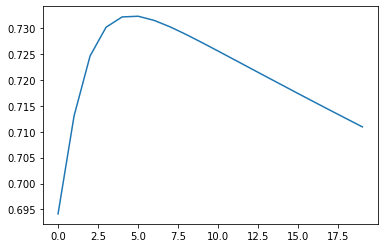

In [255]:
%matplotlib inline
plt.plot(np.array(epoch_loss))
plt.show()

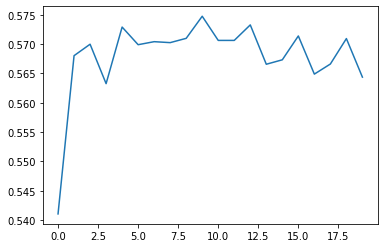

In [257]:
%matplotlib inline
#plt.plot(np.array(precision))
#plt.plot(np.array(accuracy))
#plt.plot(np.array(recall))
plt.show()

### Global Model without defferential privacy

In [205]:
model_G = Net()
optimizer_G = optim.SGD(model_G.parameters(), lr=args.lr)
criterion = nn.CrossEntropyLoss()

In [206]:
epoch_loss = []
for epoch in range(args.epochs):
    start_time = time.time()
    running_loss = 0
    print("Epoch Number = {}".format(epoch+1))
    for data, target in train_loader:
        target = target.long().view(-1)
        optimizer_G.zero_grad()
        output = model_G.forward(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer_G.step()
        running_loss += loss.item()
    running_loss /= len(test_loader.dataset)
    epoch_loss.append(running_loss)
    print("Running Loss = {}".format(running_loss))
    total_time = time.time() - start_time
    print('Time consumed {} s\n'.format(round(total_time, 2)))

Epoch Number = 1
Running Loss = 0.005118851016975466
Time consumed 10.27 s

Epoch Number = 2
Running Loss = 0.005101706569466888
Time consumed 9.3 s

Epoch Number = 3
Running Loss = 0.005096220980620455
Time consumed 8.24 s

Epoch Number = 4
Running Loss = 0.005090286024717378
Time consumed 8.33 s

Epoch Number = 5
Running Loss = 0.005082539836947492
Time consumed 8.36 s

Epoch Number = 6
Running Loss = 0.005071777527001599
Time consumed 8.28 s

Epoch Number = 7
Running Loss = 0.005056018494257952
Time consumed 11.29 s

Epoch Number = 8
Running Loss = 0.0050318569529803365
Time consumed 10.8 s

Epoch Number = 9
Running Loss = 0.004994023905097668
Time consumed 11.52 s

Epoch Number = 10
Running Loss = 0.00493465538980701
Time consumed 13.16 s

Epoch Number = 11
Running Loss = 0.004847945486543864
Time consumed 10.38 s

Epoch Number = 12
Running Loss = 0.00474061583502747
Time consumed 10.91 s

Epoch Number = 13
Running Loss = 0.004637138644049846
Time consumed 11.08 s

Epoch Number = 1

KeyboardInterrupt: 

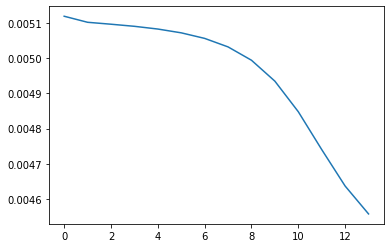

In [207]:
%matplotlib inline
plt.plot(np.array(epoch_loss))
plt.show()

In [208]:
model_G.eval()
test_loss = 0
avg_precision = 0
avg_accuracy = 0
avg_recall = 0
num_iter = 0
for data, target in test_loader:
    target = target.long()
    output = model_G(data)
    test_loss += criterion(output,target.view(-1)).item()
    prediction = output.data.max(1, keepdim=True)[1]
    target_array = target.numpy().flatten()
    prediction_array = prediction.numpy().flatten()
    precision = precision_score(target_array, prediction_array)
    avg_precision += precision
    accuracy = accuracy_score(target_array, prediction_array)
    avg_accuracy += accuracy
    recall = recall_score(target_array, prediction_array)
    avg_recall += recall
    num_iter += 1
    print("Precision = {}".format(precision))
    print("Recall = {}".format(recall))
    print("Accuracy = {}".format(accuracy))

test_loss /= len(test_loader.dataset)
avg_precision /= num_iter #len(test_loader.dataset)
avg_accuracy /= num_iter #len(test_loader.dataset)
avg_recall /= num_iter #len(test_loader.dataset)
print('Test set: Average loss: {:.4f}'.format(test_loss))

Precision = 0.10822510822510822
Recall = 0.6756756756756757
Accuracy = 0.564
Precision = 0.12317327766179541
Recall = 0.7468354430379747
Accuracy = 0.56
Precision = 0.1411042944785276
Recall = 0.7931034482758621
Accuracy = 0.562
Precision = 0.10251046025104603
Recall = 0.6805555555555556
Accuracy = 0.548
Precision = 0.12903225806451613
Recall = 0.810126582278481
Accuracy = 0.553
Precision = 0.1115702479338843
Recall = 0.6506024096385542
Accuracy = 0.541
Precision = 0.13250517598343686
Recall = 0.7804878048780488
Accuracy = 0.563
Precision = 0.10743801652892562
Recall = 0.7536231884057971
Accuracy = 0.551
Precision = 0.14556962025316456
Recall = 0.7582417582417582
Accuracy = 0.573
Precision = 0.12133891213389121
Recall = 0.7945205479452054
Accuracy = 0.565
Precision = 0.13580246913580246
Recall = 0.7764705882352941
Accuracy = 0.561
Precision = 0.10995850622406639
Recall = 0.7361111111111112
Accuracy = 0.552
Precision = 0.13916500994035785
Recall = 0.7692307692307693
Accuracy = 0.546
Pre

In [209]:
avg_precision

0.1272305195190791

In [210]:
avg_accuracy

0.5602527736804978

In [211]:
avg_recall

0.7583756337877099

In [224]:
import diffprivlib
import sklearn
from diffprivlib.models import LogisticRegression

/home/sidroy/anaconda3/envs/pysyft/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:218: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/sidroy/anaconda3/envs/pysyft/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:218: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  "privacy leakage, specify `data_norm` at initialisation.", PrivacyLeakWarning)
/home/sidroy/anaconda3/envs/pysyft/lib/python3.6/site-packages/diffprivlib/models/logistic_regression.py:218: Priv

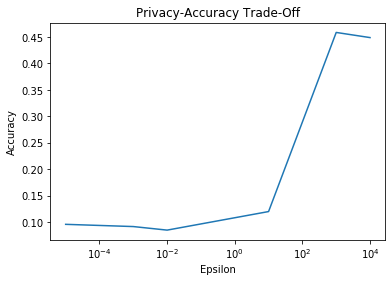

In [230]:
data_train = credit_X_train.to_numpy()
labels_train = credit_Y_train.to_numpy().flatten()
data_test = credit_X_test.to_numpy()
labels_test = credit_Y_test.to_numpy().flatten()

def sweep(eps=[0.00001, 0.001, 0.01, 10, 1000, 10000]):
    accuracy = []
    for i in range(len(eps)):
        model = LogisticRegression(epsilon=eps[i],max_iter=10000,tol=0.000001)
        model.fit(data_train, labels_train)
        accuracy.append(sklearn.metrics.precision_score(labels_test, model.predict(data_test)))
    return accuracy 

eps=[0.00001, 0.001, 0.01, 10, 1000, 10000] 

accuracy = sweep(eps)


plt.figure() # notice that the accuracy for each value changes every time you run it with the same values 
plt.semilogx(eps, accuracy) # this is because random noise is... well, random, so the accuracy shifts a bit based on how the data was altered each time! 
plt.title('Privacy-Precision Trade-Off')
plt.xlabel('Epsilon')
plt.ylabel('Precision')
plt.show()